In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def convert_seconds_to_hms(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return int(hours), int(minutes), float(seconds)

# Training a neural network on the GPU

**NOTE:**
For this notebook, you will need to have a GPU available. 
If your local computer does not have a [JAX-compatible compatible GPU](https://jax.readthedocs.io/en/latest/installation.html#supported-platforms), you can use the GPUs provided by Google Colab Pro. 
See [this guide](https://www.geeksforgeeks.org/how-to-use-gpu-in-google-colab/) on how to access GPUs on Google Colab. 

## Why GPUs?

In non-trivial scientific machine learning tasks, we often need to use graphics processing units (GPUs) to accelerate computation. 
GPUs are a type of hardware that is optimized for parallel operations such as matrix multiplication, which is core to most machine learning algorithms.

In this notebook, we'll compare GPU vs. CPU runtime for training a convolutional neural network (CNN) classifier on the MNIST dataset (i.e., the "handwritten digits" dataset). 

## Creating a CNN classifier for MNIST dataset

In [2]:
# Hyperparameters

BATCH_SIZE = 64
LEARNING_RATE = 3e-4
MAX_EPOCHS = 2
MAX_STEPS = 100
PRINT_EVERY = 10
SEED = 5678

import jax.random as jrandom
key = jrandom.PRNGKey(SEED)

Let's load the MNIST dataset:

In [3]:
import torch, torchvision

normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

The MNIST dataset consists of 28-by-28 pixel, grayscale images of handwritten digits (0-9) that look like this:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(images, labels):
    ncols = len(labels)
    nrows = int(np.ceil(len(images) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    for ax in axes.ravel():
        ax.axis("off")
    for ax, image, label in zip(axes.ravel(), images, labels):
        ax.imshow(image.squeeze(), cmap="gray")
        ax.set_title(label)
    plt.tight_layout()

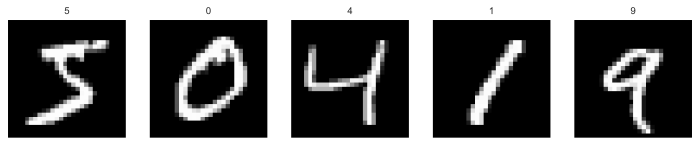

In [4]:
# Visualize random digits
images, labels = zip(*[train_dataset[i] for i in range(5)])
show_images(images, labels)

Let's define the CNN:

In [5]:
import jax
import jax.numpy as jnp
from jax import vmap
import equinox as eqx
from jaxtyping import Array, Float, Int, PyTree

class CNN(eqx.Module):
    """Convolutional neural network for classifying handwritten digits from the MNIST dataset."""
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = jrandom.split(key, 4)
        self.layers = [
            eqx.nn.Conv2d(1, 32, kernel_size=3, key=key1),
            jax.nn.relu,
            eqx.nn.MaxPool2d(kernel_size=2),
            eqx.nn.Conv2d(32, 64, kernel_size=3, key=key2),
            jax.nn.relu,
            eqx.nn.MaxPool2d(kernel_size=2),
            jnp.ravel,
            eqx.nn.Linear(30976, 128, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(128, 10, key=key4),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:  # Side note: These are shaped-array type hints, made possible by the package jaxtyping.
        for layer in self.layers:
            x = layer(x)
        return x

And finally, here is the training code (modified from [this equinox tutorial](https://docs.kidger.site/equinox/examples/mnist/)), wrapped in the function `train` for convenience:

In [6]:
from time import time
import optax

optim = optax.adamw(LEARNING_RATE)

@eqx.filter_jit
def loss(
    model: CNN, 
    x: Float[Array, "batch 1 28 28"],  
    y: Int[Array, "batch"]
) -> Float[Array, ""]:
    pred_y = vmap(model)(x)
    return cross_entropy(y, pred_y)

def cross_entropy(
    y: Int[Array, "batch"], 
    pred_y: Float[Array, "batch 10"]
) -> Float[Array, ""]:
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)

@eqx.filter_jit
def compute_accuracy(
    model: CNN, 
    x: Float[Array, "batch 1 28 28"], 
    y: Int[Array, "batch"]
) -> Float[Array, ""]:
    """This function takes as input the current model
    and computes the average accuracy on a batch.
    """
    pred_y = vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)

def evaluate(model: CNN, testloader: torch.utils.data.DataLoader):
    """This function evaluates the model on the test dataset,
    computing both the average loss and the average accuracy.
    """
    avg_loss = 0
    avg_acc = 0
    for x, y in testloader:
        x = x.numpy()
        y = y.numpy()
        avg_loss += loss(model, x, y)
        avg_acc += compute_accuracy(model, x, y)
    return avg_loss / len(testloader), avg_acc / len(testloader)

def train(
    model: CNN,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    max_epochs: int,
    max_steps: int,
    print_every: int,
) -> CNN:
    """Trains the CNN."""

    # Initialise the optimizer state.
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: CNN,
        opt_state: PyTree,
        x: Float[Array, "batch 1 28 28"],
        y: Int[Array, " batch"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Training loop
    step = 0
    max_steps_reached = False
    start_time = time()
    for epoch in range(max_epochs):
        for x, y in trainloader:
            x = x.numpy()
            y = y.numpy()
            model = eqx.nn.inference_mode(model, value=False)
            model, opt_state, train_loss = make_step(model, opt_state, x, y)
            if (step % print_every) == 0:
                model = eqx.nn.inference_mode(model, value=True)
                test_loss, test_accuracy = evaluate(model, testloader)
                hr, min, sec = convert_seconds_to_hms(time() - start_time)
                print(
                    f"elapsed_time = {hr:1d}h {min:1d}m {sec:.1f}s, {epoch=}, {step=}, train_loss={train_loss.item():.2f}, "
                    f"test_loss={test_loss.item():.2f}, test_accuracy={test_accuracy.item():.3f}"
                )
            step += 1
            if step >= max_steps:
                max_steps_reached = True
                print("Training complete. (Maximum number of steps reached.)")
                break
        if max_steps_reached:
            break
    if not max_steps_reached:
        print("Training complete.")
    hr, min, sec = convert_seconds_to_hms(time() - start_time)
    print(f"Total elapsed_time = {hr:1d}h {min:1d}m {sec:.1f}s")
    return model

## JAX devices

Before we start training, let's talk a bit about JAX devices.

JAX will automatically detect all available devices (e.g., CPU, GPU) to use for computation. Let's look at what devices are available:

In [30]:
print("CPU devices: ", jax.devices('cpu'))
try:
    is_gpu_avail = True
    print("GPU devices: ", jax.devices('gpu'))
except RuntimeError as e:
    is_gpu_avail = False
    print("GPU devices: ", e)

CPU devices:  [CpuDevice(id=0)]
GPU devices:  [cuda(id=0)]


If a GPU device was detected, then JAX will automatically make GPU the default backend. Otherwise, CPU is the default backend. Unless otherwise specified, *JAX will do all computations in the default backend*.

In [31]:
print('The default backend is:', jax.default_backend())

The default backend is: gpu


In short, ***JAX will automatically use the GPU if available*** (provided that you have installed the correct version of JAX compatible with your GPU). This is very convenient!

## Committing arrays to a device

In some cases, you may want to manually "force" computations to happen on devices/backends other than the default one. You do this by ***committing*** JAX arrays to a device. Then, all subsequent operations on that array will happen on the *committed* device. This is accomplished using the function [`jax.device_put`](https://jax.readthedocs.io/en/latest/_autosummary/jax.device_put.html#jax.device_put). See the [JAX FAQ](https://jax.readthedocs.io/en/latest/faq.html#controlling-data-and-computation-placement-on-devices) for more details. 

Let's demonstrate this. First, we initialize our model:

In [32]:
model = CNN(key=key)  # An instance of our CNN class.

All the arrays in the pytree `model` are uncommitted, so subsequent operations on `model` will happen on the default device. Since our goal is to compare CPU and GPU runtimes, we will make two copies of `model`&mdash;one on CPU and the other on GPU.

Let's do it:

In [35]:
# Helper functions for committing JAX arrays to a GPU or CPU
put_on_cpu = lambda x: jax.device_put(x, jax.devices('cpu')[0]) if isinstance(x, jax.Array) else x
put_on_gpu = lambda x: jax.device_put(x, jax.devices('gpu')[0]) if isinstance(x, jax.Array) else x

key, key_gpu, key_cpu = jrandom.split(key, 3)
model_cpu = jax.tree.map(put_on_cpu, CNN(key=key_cpu))
if is_gpu_avail:
    model_gpu = jax.tree.map(put_on_gpu, CNN(key=key_gpu))
else:
    print("GPU not available.")

Great! All arrays in `model_cpu` are committed to CPU, and all arrays in `model_gpu` are committed to GPU. Let's check one of the arrays just to be sure:

In [34]:
print('The CPU\'s copy of model is on: ', model_cpu.layers[0].weight.devices())
if is_gpu_avail:
    print('The GPU\'s copy of model is on: ', model_gpu.layers[0].weight.devices())
else:
    print("GPU not available.")

The CPU's copy of model is on:  {CpuDevice(id=0)}
The GPU's copy of model is on:  {cuda(id=0)}


Perfect. We are now ready to benchmark.

## CPU vs. GPU runtime

Let's start by training on CPU (this may take a few minutes):

In [8]:
print("Begin training on CPU.")
trained_model_cpu = train(model_cpu, trainloader, testloader, optim, MAX_EPOCHS, MAX_STEPS, PRINT_EVERY)

Begin training on CPU.
elapsed_time = 0h 0m 32.0s, epoch=0, step=0, train_loss=2.31, test_loss=2.28, test_accuracy=0.193
elapsed_time = 0h 1m 3.2s, epoch=0, step=10, train_loss=1.11, test_loss=1.04, test_accuracy=0.721
elapsed_time = 0h 1m 37.8s, epoch=0, step=20, train_loss=0.55, test_loss=0.58, test_accuracy=0.815
elapsed_time = 0h 2m 7.9s, epoch=0, step=30, train_loss=0.40, test_loss=0.43, test_accuracy=0.862
elapsed_time = 0h 2m 49.0s, epoch=0, step=40, train_loss=0.44, test_loss=0.38, test_accuracy=0.884
elapsed_time = 0h 3m 19.7s, epoch=0, step=50, train_loss=0.46, test_loss=0.32, test_accuracy=0.909
elapsed_time = 0h 3m 52.6s, epoch=0, step=60, train_loss=0.24, test_loss=0.27, test_accuracy=0.922
elapsed_time = 0h 4m 22.7s, epoch=0, step=70, train_loss=0.14, test_loss=0.27, test_accuracy=0.919
elapsed_time = 0h 4m 53.1s, epoch=0, step=80, train_loss=0.28, test_loss=0.23, test_accuracy=0.935
elapsed_time = 0h 5m 23.1s, epoch=0, step=90, train_loss=0.38, test_loss=0.22, test_accur

This is fairly slow. Let's try training on GPU:

In [ ]:
print("Begin training on GPU.")
trained_model_gpu = train(model_gpu, trainloader, testloader, optim, MAX_EPOCHS, MAX_STEPS, PRINT_EVERY)

Begin training on GPU.
elapsed_time = 0h 0m 3.6s, epoch=0, step=0, train_loss=2.31, test_loss=2.30, test_accuracy=0.195
elapsed_time = 0h 0m 6.9s, epoch=0, step=10, train_loss=1.21, test_loss=1.13, test_accuracy=0.698
elapsed_time = 0h 0m 10.7s, epoch=0, step=20, train_loss=0.54, test_loss=0.54, test_accuracy=0.829
elapsed_time = 0h 0m 13.5s, epoch=0, step=30, train_loss=0.55, test_loss=0.41, test_accuracy=0.868
elapsed_time = 0h 0m 16.3s, epoch=0, step=40, train_loss=0.38, test_loss=0.40, test_accuracy=0.871
elapsed_time = 0h 0m 19.1s, epoch=0, step=50, train_loss=0.22, test_loss=0.34, test_accuracy=0.897
elapsed_time = 0h 0m 22.8s, epoch=0, step=60, train_loss=0.44, test_loss=0.28, test_accuracy=0.920
elapsed_time = 0h 0m 25.7s, epoch=0, step=70, train_loss=0.27, test_loss=0.27, test_accuracy=0.924
elapsed_time = 0h 0m 28.8s, epoch=0, step=80, train_loss=0.33, test_loss=0.23, test_accuracy=0.937
elapsed_time = 0h 0m 31.6s, epoch=0, step=90, train_loss=0.26, test_loss=0.22, test_accur

Much faster! Using the GPU resulted in 5-10X speedup over CPU for this small example. For larger models, the speedup will be even more dramatic. This is why virtually all modern deep learning models are trained on GPUs.